# Imbalanced Dataset Training Test

아래처럼 실행
```
jupyter lab --ServerApp.iopub_msg_rate_limit=1.0e10
```

In [9]:
import os
import shutil
from pathlib import Path

import matplotlib.pylab as plt
import numpy as np
import pandas as pd

# Make Imbalaced Dataset

x_data: (150000, 10)
y_data: [134428, 15572]
x_train: (105000, 10)
y_train: [94100, 10900]
x_test: (45000, 10)
y_test: [40328, 4672]


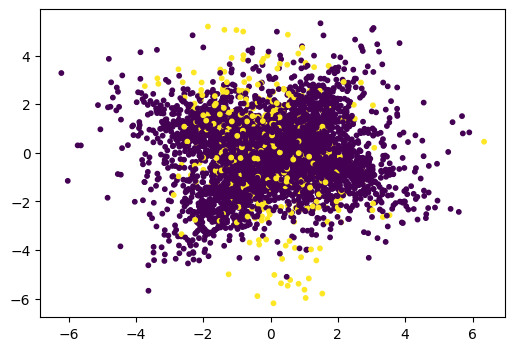

In [2]:
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

np.random.seed(0)
x_data, y_data = make_classification(
    n_samples=150000,
    n_features=8,
    n_informative=4,
    n_clusters_per_class=3,
    class_sep=0.6,
    weights=(0.9, 0.1),
    hypercube=False,
)
x_data = pd.DataFrame(x_data)
x_data.columns = [str(c) for c in x_data.columns]
x_data["rand1"] = np.random.rand(x_data.shape[0])
x_data["rand2"] = np.random.rand(x_data.shape[0])

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, stratify=y_data)


print("x_data:", x_data.shape)
print("y_data:", pd.Series(y_data).value_counts().tolist())

print("x_train:", x_train.shape)
print("y_train:", pd.Series(y_train).value_counts().tolist())

print("x_test:", x_test.shape)
print("y_test:", pd.Series(y_test).value_counts().tolist())


pca = PCA(n_components=2)
pca_data = pca.fit_transform(x_data, y_data)
fig, plot = plt.subplots(1, figsize=(6, 4))
plot.scatter(pca_data[:5000, 0], pca_data[:5000, 1], c=y_data[:5000], marker="o", s=10)

# Model

## Logistic Regression

In [301]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score

weight = (y_test == 1).sum() / len(y_test)
model = LogisticRegression(class_weight=(weight, 1 - weight))
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

y_true_count = ((y_test == y_pred) & (y_pred != 0)).sum()

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))
print(f"{y_true_count} / {sum(y_test)} = {y_true_count / sum(y_test)}")

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     40328
           1       0.91      0.00      0.00      4672

    accuracy                           0.90     45000
   macro avg       0.90      0.50      0.47     45000
weighted avg       0.90      0.90      0.85     45000

Accuracy : 0.8963777777777778
Precision: 0.9090909090909091
Recall   : 0.0021404109589041095
F1 Score : 0.004270766602605167
10 / 4672 = 0.0021404109589041095


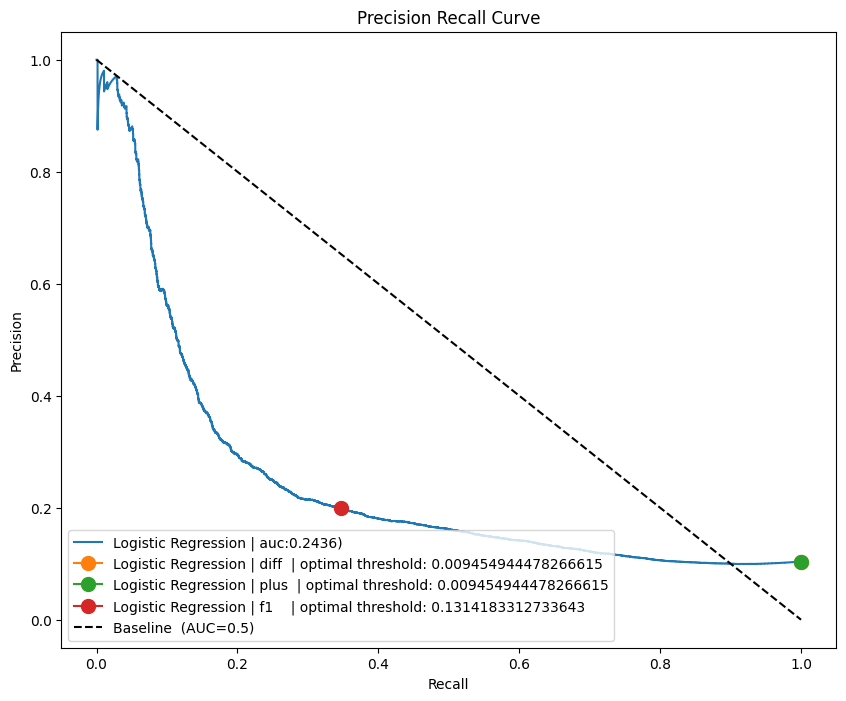

In [303]:
from sklearn.metrics import accuracy_score, auc, f1_score, precision_recall_curve


def calculate_prauc(y_true, y_prob, plot, label, method=[]):
    from collections.abc import Iterable

    def point_optimal_threshold(name):
        # Other Metrics at the max_threshold

        acc_ = accuracy_score(y_true, y_prob >= max_threshold)
        f1_ = f1_score(y_test, y_prob >= max_threshold)

        plot.plot(
            recall[max_idx],
            precision[max_idx],
            marker="o",
            markersize=10,
            label=f"{label} | {name:5} | optimal threshold: {max_threshold}",
        )

    if not isinstance(method, Iterable):
        method = [method]

    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    auc_ = auc(recall, precision)
    plot.plot(recall, precision, label=f"{label} | auc:{auc_:.4f})")

    # Optimize the thesholds
    best_threshold = None
    if "diff" in method:
        max_idx = np.argmax(recall - precision)
        max_threshold = thresholds[max_idx]
        point_optimal_threshold("diff")
        best_threshold = max_threshold

    if "plus" in method:
        max_idx = np.argmax(recall + precision)
        max_threshold = thresholds[max_idx]
        point_optimal_threshold("plus")
        best_threshold = max_threshold

    if "f1" in method:
        fscores = 2 * (precision * recall) / (precision + recall)
        max_idx = np.argmax(fscores)
        max_threshold = thresholds[max_idx]
        point_optimal_threshold("f1")
        best_threshold = max_threshold
    return best_threshold


y_prob = model.predict_proba(x_test)[:, 1]

fig, plot = plt.subplots(1, figsize=(10, 8))
calculate_prauc(y_test, y_prob, plot, "Logistic Regression", ("diff", "plus", "f1"))

plot.plot([0, 1], [1, 0], "k--", label=f"Baseline  (AUC=0.5)")
plot.set_xlabel("Recall")
plot.set_ylabel("Precision")
plot.set_title(f"Precision Recall Curve")
plot.legend(loc="lower left")

## Decision Tree

In [304]:
from sklearn.tree import DecisionTreeClassifier

class_weight = {0:sum(train_labels == 1) / len(train_labels), 1:sum(train_labels == 0) / len(train_labels)}
model = DecisionTreeClassifier(max_depth=10)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

y_true_count = ((y_test == y_pred) & (y_pred != 0)).sum()

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))
print(f"{y_true_count} / {sum(y_test)} = {y_true_count / sum(y_test)}")

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     40328
           1       0.75      0.33      0.46      4672

    accuracy                           0.92     45000
   macro avg       0.84      0.66      0.71     45000
weighted avg       0.91      0.92      0.90     45000

Accuracy : 0.9191777777777778
Precision: 0.7482014388489209
Recall   : 0.3339041095890411
F1 Score : 0.4617433772384194
1560 / 4672 = 0.3339041095890411


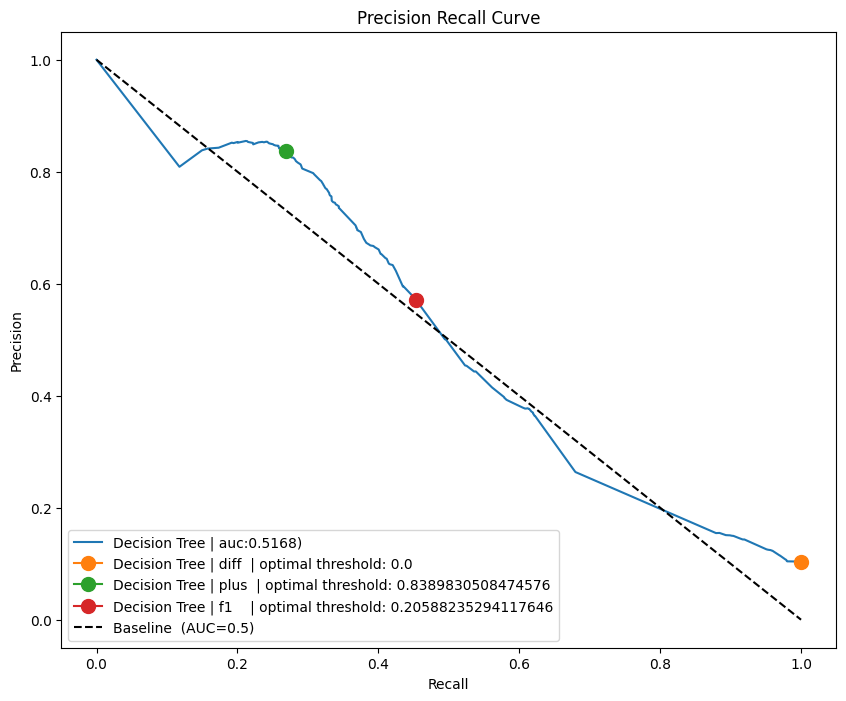

In [305]:
y_prob = model.predict_proba(x_test)[:, 1]

fig, plot = plt.subplots(1, figsize=(10, 8))
calculate_prauc(y_test, y_prob, plot, "Decision Tree", ("diff", "plus", "f1"))

plot.plot([0, 1], [1, 0], "k--", label=f"Baseline  (AUC=0.5)")
plot.set_xlabel("Recall")
plot.set_ylabel("Precision")
plot.set_title(f"Precision Recall Curve")
plot.legend(loc="lower left")

## LightGBM

/home/anderson/.pyenv/versions/3.7.16/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: n_estimator
scale_pos_weight: 0.8961904761904762
Accuracy : 0.9258222222222222
Precision: 0.8338338338338338
Recall   : 0.3565924657534247
F1 Score : 0.49955022488755624


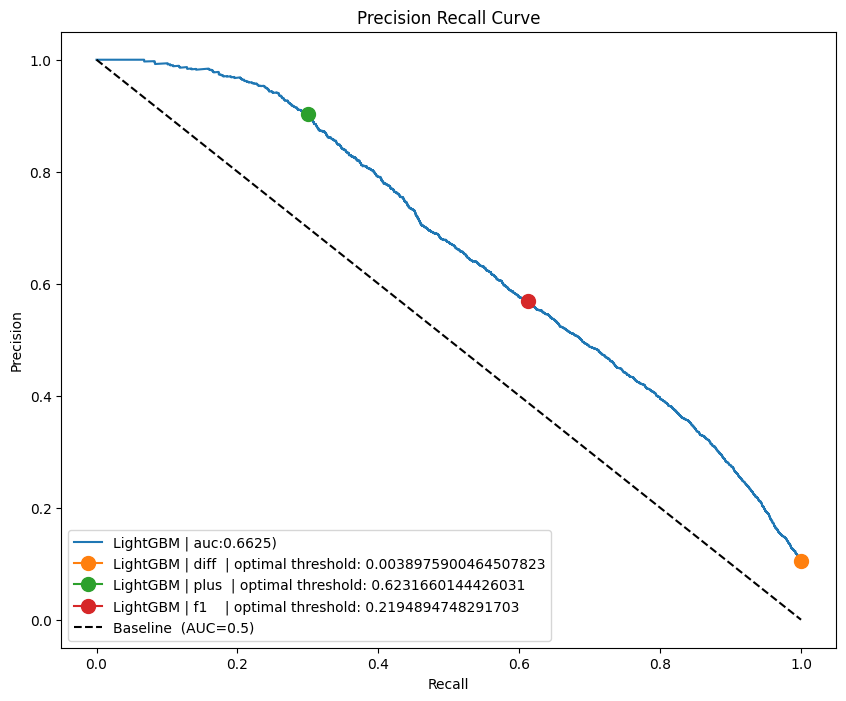

In [290]:
import lightgbm as lgb

train_features, valid_features, train_labels, valid_labels = train_test_split(
    x_train, y_train, test_size=0.2, stratify=y_train
)

scale_pos_weight = sum(train_labels == 0) / len(train_labels)
clf = lgb.LGBMClassifier(max_depth=30, n_estimator=400, scale_pos_weight=scale_pos_weight, random_state=100)
clf.fit(train_features, train_labels, 
       eval_set=[(valid_features, valid_labels)],
       eval_metric='prauc', 
       verbose=0)

y_pred = clf.predict_proba(x_test)[:, 1] >= 0.5

print('scale_pos_weight:', scale_pos_weight)
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))

y_prob = clf.predict_proba(x_test)[:, 1]

fig, plot = plt.subplots(1, figsize=(10, 8))
calculate_prauc(y_test, y_prob, plot, "LightGBM", ("diff", "plus", "f1"))

plot.plot([0, 1], [1, 0], "k--", label=f"Baseline  (AUC=0.5)")
plot.set_xlabel("Recall")
plot.set_ylabel("Precision")
plot.set_title(f"Precision Recall Curve")
plot.legend(loc="lower left")

## Class Weights

In [245]:
from abc import ABC
from tempfile import gettempdir

import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

pl.seed_everything(1000)


class TabularDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


train_features, valid_features, train_labels, valid_labels = train_test_split(
    x_train, y_train, test_size=0.2, stratify=y_train
)

train_dataset = TabularDataset(train_features.values.astype("float32"), train_labels)
valid_dataset = TabularDataset(valid_features.values.astype("float32"), valid_labels)
test_dataset = TabularDataset(x_test.values.astype("float32"), y_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, num_workers=4, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=32, num_workers=4)

class_weights = torch.tensor((y_train == 0).sum() / (y_train == 1).sum(), dtype=torch.float)
print("class_weights:", class_weights)


class BinaryClassifier(pl.LightningModule, ABC):
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)

        loss = self.loss(logits, y.float().unsqueeze(1))
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y.float().unsqueeze(1))
        self.log("val_loss", loss)
        return {"y_prob": logits.detach(), "y_true": y.detach()}

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)

        loss = self.loss(logits, y.float().unsqueeze(1))
        self.log("test_loss", loss)
        return {"y_prob": logits.detach(), "y_true": y.detach()}

    def validation_epoch_end(self, outputs):
        y_prob = torch.cat([x["y_prob"] for x in outputs])
        y_true = torch.cat([x["y_true"] for x in outputs])

        y_prob = y_prob.cpu().numpy()
        y_true = y_true.cpu().numpy()

        precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
        prauc = auc(recall, precision)

        self.log("val_prauc", prauc, on_step=False, on_epoch=True, prog_bar=True, logger=True)

    def test_epoch_end(self, outputs):
        y_prob = torch.cat([x["y_prob"] for x in outputs])
        y_true = torch.cat([x["y_true"] for x in outputs])

        y_prob = y_prob.cpu().numpy()
        y_true = y_true.cpu().numpy()

        precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
        prauc = auc(recall, precision)

        fig, plot = plt.subplots(1, figsize=(10, 8))
        threshold = calculate_prauc(y_true, y_prob, plot, "Deep Learning", ("diff", "plus", "f1"))

        plot.plot([0, 1], [1, 0], "k--", label=f"Baseline  (AUC=0.5)")
        plot.set_xlabel("Recall")
        plot.set_ylabel("Precision")
        plot.set_title(f"Precision Recall Curve")
        plot.legend(loc="lower left")

        y_pred = y_prob.reshape(-1) >= 0.5
        self.log(
            "test_accuracy", accuracy_score(y_true, y_pred), on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        self.log(
            "test_precision", precision_score(y_true, y_pred), on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        self.log("test_recall", recall_score(y_true, y_pred), on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("test_f1", f1_score(y_true, y_pred), on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("test_prauc", prauc, on_step=False, on_epoch=True, prog_bar=True, logger=True)


# 모델 정의
class DeepLearningModel(BinaryClassifier):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.save_hyperparameters()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(32)
        self.loss = nn.BCEWithLogitsLoss(pos_weight=class_weights)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.batchnorm1(x)
        x = self.relu(self.layer3(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.output(x)
        x = torch.sigmoid(x)
        return x

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)


# 모델 훈련
checkpoint_path = Path(gettempdir()) / "anderson_ml" / "pytorch_deep_learning" / "checkpoints"
checkpoint_callback = ModelCheckpoint(
    monitor="val_prauc",
    dirpath=checkpoint_path,
    filename="model-{epoch:02d}-{val_loss:.4f}-{val_prauc:.4f}",
    verbose=False,
    save_top_k=1,
    mode="max",
)

if checkpoint_path.exists():
    shutil.rmtree(checkpoint_path)
model = DeepLearningModel(input_dim=x_train.shape[1])
trainer = pl.Trainer(max_epochs=15, gpus=1, callbacks=[checkpoint_callback])
trainer.fit(model, train_dataloader, valid_dataloader)

Global seed set to 1000
/home/anderson/.pyenv/versions/3.7.16/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:479: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | P

class_weights: tensor(8.6330)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


model-epoch=10-val_loss=1.0306-val_prauc=0.6769.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8727777777777778
         test_f1            0.5718986016600613
        test_loss           1.0292149782180786
       test_prauc           0.6785424616612266
     test_precision          0.439489713825997
       test_recall          0.8184931506849316
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.0292149782180786,
  'test_accuracy': 0.8727777777777778,
  'test_precision': 0.439489713825997,
  'test_recall': 0.8184931506849316,
  'test_f1': 0.5718986016600613,
  'test_prauc': 0.6785424616612266}]

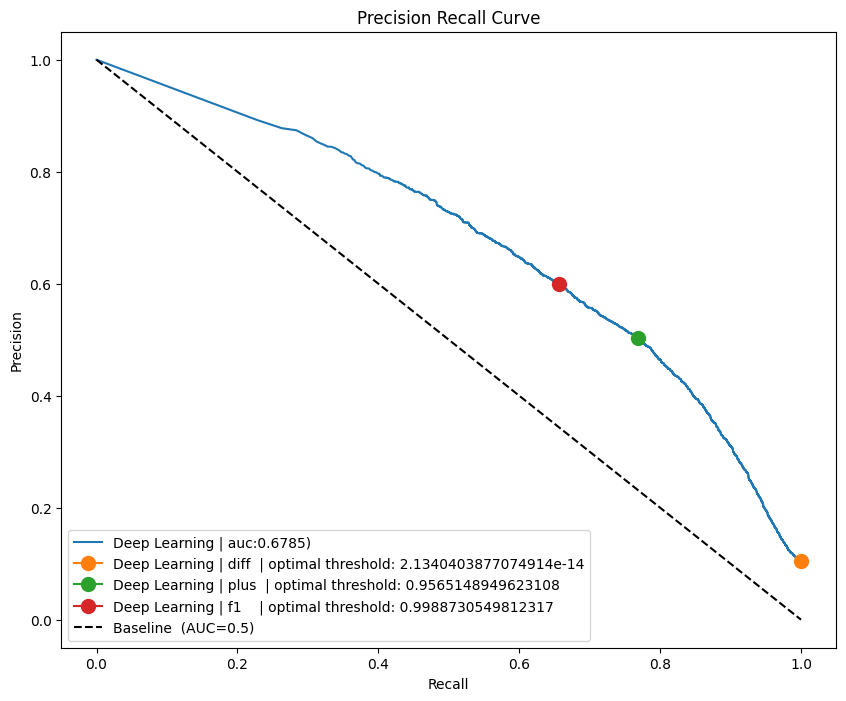

In [247]:
best_checkpoint_path = checkpoint_path / os.listdir(checkpoint_path)[0]
print(os.listdir(checkpoint_path)[0])
model = DeepLearningModel.load_from_checkpoint(best_checkpoint_path)
model.eval()
trainer.test(model, test_dataloader)

## Transformer

In [243]:
import math


class TransformerClassifier(BinaryClassifier):
    def __init__(self, d_model: int, nhead: int = 5, dim_feedforward: int = 64, num_layers: int = 6):
        super().__init__()
        self.save_hyperparameters()
        self.encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 1)
        self.d_model = d_model
        self.loss = nn.BCEWithLogitsLoss(pos_weight=class_weights)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        x = self.transformer_encoder(x)
        x = self.decoder(x)
        return x

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())


# 모델 훈련
pl.seed_everything(1000)
checkpoint_path = Path(gettempdir()) / "anderson_ml" / "pytorch_transformer" / "checkpoints"
checkpoint_callback = ModelCheckpoint(
    monitor="val_prauc",
    dirpath=checkpoint_path,
    filename="model-{epoch:02d}-{val_loss:.4f}-{val_prauc:.4f}",
    verbose=False,
    save_top_k=1,
    mode="max",
)

if checkpoint_path.exists():
    shutil.rmtree(checkpoint_path)
model = TransformerClassifier(d_model=x_train.shape[1])
trainer = pl.Trainer(max_epochs=30, gpus=1, callbacks=[checkpoint_callback])
trainer.fit(model, train_dataloader, valid_dataloader)

Global seed set to 1000
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                    | Params
----------------------------------------------------------------
0 | encoder_layers      | TransformerEncoderLayer | 1.8 K 
1 | transformer_encoder | TransformerEncoder      | 11.0 K
2 | decoder             | Linear                  | 11    
3 | loss                | BCEWithLogitsLoss       | 0     
---------------------------------------------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


model-epoch=22-val_loss=0.6449-val_prauc=0.6946.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8816888888888889
         test_f1            0.5812490168318389
        test_loss           0.6414273977279663
       test_prauc           0.6903997091192585
     test_precision         0.4594628201939816
       test_recall          0.7908818493150684
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.6414273977279663,
  'test_accuracy': 0.8816888888888889,
  'test_precision': 0.4594628201939816,
  'test_recall': 0.7908818493150684,
  'test_f1': 0.5812490168318389,
  'test_prauc': 0.6903997091192585}]

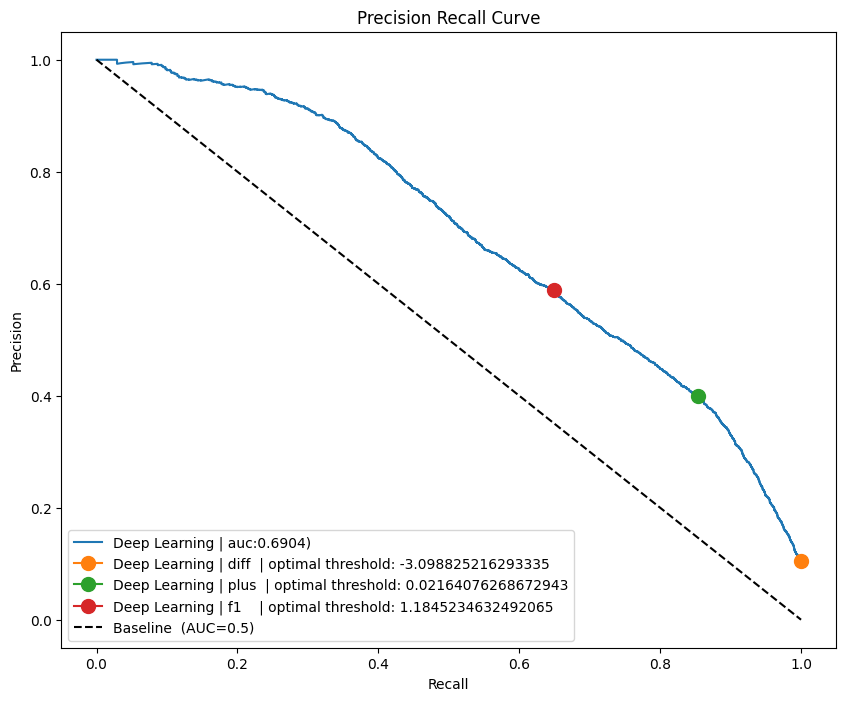

In [244]:
best_checkpoint_path = checkpoint_path / os.listdir(checkpoint_path)[0]
print(os.listdir(checkpoint_path)[0])
model = TransformerClassifier.load_from_checkpoint(best_checkpoint_path)
model.eval()
trainer.test(model, test_dataloader)